>>## Sentiment Analysis project in NLP - (fellowship.ai)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# importing all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Dense , Dropout,LSTM ,Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import os, pickle
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Reading data from the csv file

In [2]:
data = pd.read_csv('Data/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
data.info()        # to print all the information of about data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


### to check imbalancity of our data

In [ ]:

data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
values = list(data['sentiment'].value_counts().values)
key = list(data['sentiment'].value_counts().keys())

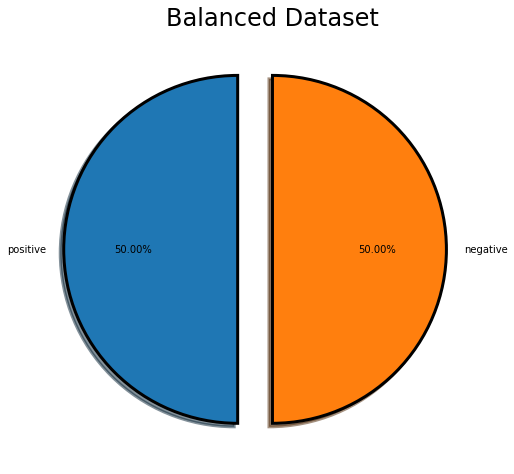

In [ ]:
plt.figure(figsize=(8,8))
ex = [0.2,0]
plt.pie(values,labels=key,shadow=True,wedgeprops={'edgecolor':'k','lw':'3'},explode=ex,startangle=90,autopct='%1.2f%%')
plt.title('Balanced Dataset ',fontsize = 24)
plt.show()

### now we can say this balance dataset

## statistical analysis

In [ ]:
maximum_lenght = (data['review'].map(len)).max()  
maximum_lenght

# maximum length of review in our dataset

13704

In [ ]:
minimum_lenght = (data['review'].map(len)).min()
minimum_lenght

# minimum length of review in our dataset

32

In [ ]:
# to print the first review

data['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
data['char_lenght'] = data['review'].map(len)

# to define a new feature filling by charcter length of particular review

In [ ]:
data.head()
# new feature has been added in our dataset

,review,sentiment,char_lenght
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there's a family where a little boy ...,negative,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317


### purpose of this feature  -->  char_lenght
<p>i created this feature. to know better about the review.<br>
    because according to the lenght distribution i will consider only those<br>
    review which has minimum character length to the mean or median.
    and mean and median i will select on the basis of char_lenght distribution.<br>
    if it will be normally distributed then i will choose mean , otherwise i will go <br>
    with median !
</p>

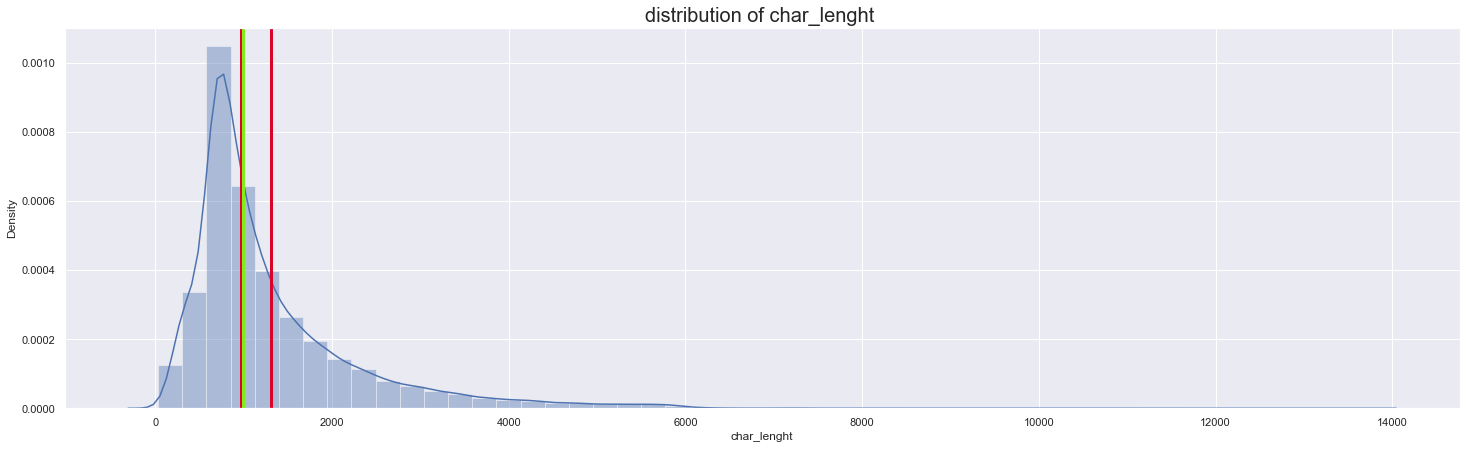

In [ ]:
## graphical distribution of my char_lenght of review

sns.set(rc={'figure.figsize':(25,7)})
sns.distplot(data['char_lenght'])
plt.title('distribution of char_lenght ',fontdict={'fontsize':20})
plt.axvline(data['char_lenght'].mean(),color='#d90429',linewidth=3)
plt.axvline(data['char_lenght'].median(),color='#d90429',linewidth=3)
plt.axvline(data['char_lenght'].std(),color='#85EA1A',linewidth=3)
plt.show()

### report
<p>Now i can easily see, this is not normally distributed, wo i will go with the median value.<br>
    by the vertical line you can easily see where the mean and median and standard deviation.
</p>

In [ ]:
# statistical representation of char_lenght feature
data.describe()

,char_lenght
count,50000.000000
mean,1309.431020
std,989.728014
min,32.000000
25%,699.000000
50%,970.000000
75%,1590.250000
max,13704.000000


after removing some outliers point

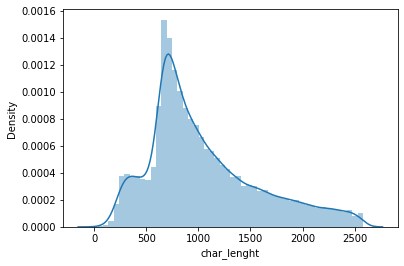

In [ ]:
sns.distplot(data[data['char_lenght']<=data['char_lenght'].quantile(q= .90)]['char_lenght'])
plt.show()

In [ ]:
new_data = data[data['char_lenght']<=data['char_lenght'].quantile(q= .90)]
new_data.head()

,review,sentiment,char_lenght
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there's a family where a little boy ...,negative,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317


In [ ]:
new_data.shape

(45002, 3)

# to declare a range of review for our model
and now i has performed some stats operation, so i can easily say that this not normally distributed
so i will choose median range.

i choosed mean, i know, i should choose median. but both are equal to each other as i seen in distribution
that,s why i choosed mean.

In [ ]:
new_data = new_data[new_data['char_lenght']<= new_data['char_lenght'].median()]
data2 = new_data[['review','sentiment']]
data2.head()

,review,sentiment
3,Basically there's a family where a little boy ...,negative
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [ ]:
data2.shape

(22512, 2)

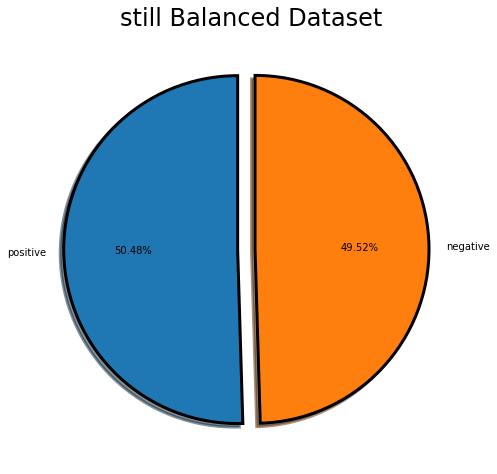

In [ ]:
values = list(data2['sentiment'].value_counts().values)
key = list(data2['sentiment'].value_counts().keys())
plt.figure(figsize=(8,8))
ex = [0.1,0]
plt.pie(values,labels=key,shadow=True,wedgeprops={'edgecolor':'k','lw':'3'},explode=ex,startangle=90,autopct='%1.2f%%')
plt.title('still Balanced Dataset ',fontsize = 24)
plt.show()

# still balanced dataset but we loosed some data point.

In [ ]:
data2['sentiment'].value_counts()

positive    11363
negative    11149
Name: sentiment, dtype: int64

In [ ]:
data2 = data2.reset_index().drop('index',axis =1)
data2.head()

,review,sentiment
0,Basically there's a family where a little boy ...,negative
1,"Probably my all-time favorite movie, a story o...",positive
2,I sure would like to see a resurrection of a u...,positive
3,Encouraged by the positive comments about this...,negative
4,If you like original gut wrenching laughter yo...,positive


## Text-Preprocessing

In [ ]:
# to remove stopwords and performe stemming

ps = PorterStemmer()
for i in range(len(data2)):
    content = re.sub('[^a-zA-Z]',' ',data2['review'][i])
    content = content.lower()
    ls_of_word = nltk.word_tokenize(content)
    removed_stopwords = [ps.stem(word) for word in ls_of_word if word not in set(stopwords.words('english'))]
    data2['review'][i] = ' '.join(removed_stopwords)
    


In [ ]:
data2.head()

,review,sentiment
0,basic famili littl boy jake think zombi closet...,negative
1,probabl time favorit movi stori selfless sacri...,positive
2,sure would like see resurrect date seahunt ser...,positive
3,encourag posit comment film look forward watch...,negative
4,like origin gut wrench laughter like movi youn...,positive


In [ ]:
print(data2['review'][0])

basic famili littl boy jake think zombi closet parent fight time br br movi slower soap opera suddenli jake decid becom rambo kill zombi br br ok first go make film must decid thriller drama drama movi watchabl parent divorc argu like real life jake closet total ruin film expect see boogeyman similar movi instead watch drama meaningless thriller spot br br well play parent descent dialog shot jake ignor


In [ ]:
# define the vocabulary size
vocabulary_size = 20000


In [1]:
one_hoted = [one_hot(reviw,vocabulary_size) for reviw in data2['review']]
one_hoted
# performing one hote encoding

In [ ]:
len(one_hoted),data2.shape[0]    # no. of data point equal

(22512, 22512)

In [ ]:
rang = data2['review'][0].split()
len(one_hoted[0]) ,len(rang)       # no. of word equal

(70, 70)

## do pad_sequnce to equalize the shape of the sentence

In [ ]:
def max_len_word_in_sent(data):
    len_of_list = []
    for i in range(len(data)):
        list_of_word = data['review'][i].split()
        len_of_list.append(len(list_of_word))
    return(max(len_of_list))


In [ ]:
max_review_lenght = max_len_word_in_sent(data2)
max_review_lenght

110

In [ ]:
data3  = pad_sequences(one_hoted,padding='pre',maxlen=max_review_lenght)
data3

array([[    0,     0,     0, ..., 17431, 16771, 17357],
       [    0,     0,     0, ...,  2655, 14727,  1118],
       [    0,     0,     0, ..., 18831,  7814,  1052],
       ...,
       [    0,     0,     0, ...,  2092,  9156,  9156],
       [    0,     0,     0, ..., 13895, 18345,  7859],
       [    0,     0,     0, ..., 10662, 18935,  1118]])

In [ ]:
len(data3[258])   # now all review has equal lenght

110

In [ ]:
len(data3)       # all are review one hoted

22512

In [ ]:
np.save(file='Data/onehotted.npy',arr=data3)   # to save the onehotted data

## to labelize the y data

In [ ]:
label_encode = dict(list(zip(list(data2['sentiment'].value_counts().index),[1,0])))
label_encode

{'positive': 1, 'negative': 0}

In [ ]:
y = data2['sentiment'].map(label_encode)

In [ ]:
y.value_counts()

1    11363
0    11149
Name: sentiment, dtype: int64

## set the X and Y variable

In [ ]:
x = data3
y = y 

In [ ]:
x.shape,y.shape

((22512, 110), (22512,))

In [ ]:
# to save independent and dependent data
pickle.dump(x,open('Data/final_data/x_data.pkl','wb'))
pickle.dump(y,open('Data/final_data/y_data','wb'))


In [4]:
x = pickle.load(open('Data/final_data/x_data.pkl','rb'))
y = pickle.load(open('Data/final_data/y_data','rb'))

## Train test split

In [5]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=42)

In [6]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((16884, 110), (16884,), (5628, 110), (5628,))

In [7]:
vocabulary_size = 20000
max_review_lenght = 110

In [8]:
vocabulary_size,max_review_lenght

(20000, 110)

## Now defining model

In [9]:
model  = Sequential()
model.add(Embedding(vocabulary_size,1000,input_length=max_review_lenght))
model.add(Dropout(0.5))
model.add(LSTM(units = 55))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer = 'adam',metrics=['accuracy'])

second model defining

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 110, 1000)         20000000  
                                                                 
 dropout (Dropout)           (None, 110, 1000)         0         
                                                                 
 lstm (LSTM)                 (None, 55)                232320    
                                                                 
 dropout_1 (Dropout)         (None, 55)                0         
                                                                 
 dense (Dense)               (None, 1)                 56        
                                                                 
Total params: 20,232,376
Trainable params: 20,232,376
Non-trainable params: 0
_________________________________________________________________


In [12]:
model_history = model.fit(x_train,y_train,epochs=5,batch_size=80,validation_data=(x_test,y_test))

Epoch 1/5
212/212 [==============================] - 177s 821ms/step - loss: 0.4014 - accuracy: 0.8197 - val_loss: 0.3149 - val_accuracy: 0.8687
Epoch 2/5
212/212 [==============================] - 166s 781ms/step - loss: 0.2038 - accuracy: 0.9257 - val_loss: 0.3215 - val_accuracy: 0.8813
Epoch 3/5
212/212 [==============================] - 167s 789ms/step - loss: 0.1300 - accuracy: 0.9554 - val_loss: 0.3505 - val_accuracy: 0.8674
Epoch 4/5
212/212 [==============================] - 164s 774ms/step - loss: 0.0985 - accuracy: 0.9669 - val_loss: 0.4072 - val_accuracy: 0.8641
Epoch 5/5
212/212 [==============================] - 154s 729ms/step - loss: 0.0863 - accuracy: 0.9709 - val_loss: 0.4514 - val_accuracy: 0.8607


### save the model

In [13]:
model.save('fellowship/model/lstm86.h5')

<AxesSubplot:>

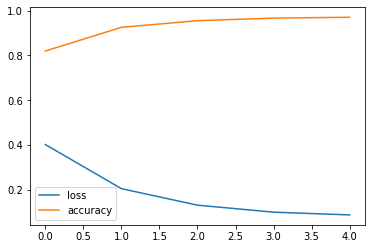

In [18]:
pd.DataFrame(model_history.history)[['loss','accuracy']].plot()

<AxesSubplot:>

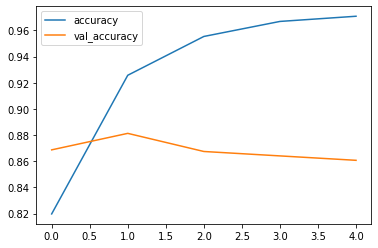

In [16]:
pd.DataFrame(model_history.history)[['accuracy','val_accuracy']].plot()


<AxesSubplot:>

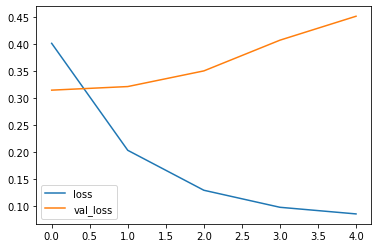

In [17]:
pd.DataFrame(model_history.history)[['loss','val_loss']].plot()


### take the prediction

In [49]:
y_pred = model.predict(x_test)

176/176 [==============================] - 1s 4ms/step


In [50]:
y_pre = y_pred>0.5
y_pre

array([[False],
       [False],
       [ True],
       ...,
       [ True],
       [ True],
       [False]])

### confusion matrix

In [51]:
confusion_matrix(y_test,y_pre)

array([[2487,  366],
       [ 399, 2376]])

### classification report

In [52]:
print(classification_report(y_test,y_pre))


              precision    recall  f1-score   support

           0       0.86      0.87      0.87      2853
           1       0.87      0.86      0.86      2775

    accuracy                           0.86      5628
   macro avg       0.86      0.86      0.86      5628
weighted avg       0.86      0.86      0.86      5628



In [59]:
y_test.values

array([0, 0, 1, ..., 1, 0, 1])

### prepare a dataset with prediction

In [60]:
pred = pd.DataFrame(x_test)
pred['actual']=y_test.values
pred['predicted'] = y_pre

In [61]:
pred.head(50)

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,actual,predicted
0,0,0,0,0,0,0,0,0,0,0,...,414,6939,15934,8256,1527,6990,7654,2896,0,False
1,0,0,0,0,0,0,0,0,0,0,...,17903,16844,7108,14798,11457,3389,19121,9093,0,False
2,0,0,0,0,0,0,0,0,0,0,...,2057,11047,18509,16166,18831,7883,2803,4196,1,True
3,0,0,0,0,0,0,0,0,0,0,...,9433,8174,7581,2085,10890,16798,10064,18554,0,False
4,0,0,0,0,0,0,0,0,0,0,...,17169,15376,9956,15347,16504,8088,13563,13191,0,False
5,0,0,0,0,0,0,0,0,0,0,...,7753,13368,19736,15107,4747,13916,7224,10864,0,False
6,0,0,0,0,0,0,0,0,0,0,...,9304,733,17257,19487,7814,17189,18887,13271,1,True
7,0,0,0,0,0,0,0,0,0,0,...,9156,10890,8988,3389,10433,2006,15060,8217,1,True
8,0,0,0,0,0,0,0,0,0,0,...,18860,4559,2774,13627,15007,2912,3403,19669,0,False
9,0,0,0,0,0,0,0,0,0,0,...,7352,12178,4301,2895,11392,8132,9156,9156,0,False


### save the prediction dataset

In [65]:
# to create a prediction directory
import os
os.makedirs('/content/drive/MyDrive/fellowship/prediction', exist_ok=True)

In [66]:
pred.to_csv('/content/drive/MyDrive/fellowship/prediction/predict.csv',index=False)
## to save the prediction dataset as a .csv file

# Thank you 🎯